# Анализ результатов IELTS методами ML

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
data = pd.read_csv('data/final_data.csv', sep=';')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 49 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Task_Type                              1432 non-null   int64  
 1   Overall                                1432 non-null   float64
 2   A1                                     1432 non-null   int64  
 3   A2                                     1432 non-null   int64  
 4   B1                                     1432 non-null   int64  
 5   B2                                     1432 non-null   int64  
 6   C1                                     1432 non-null   int64  
 7   C2                                     1432 non-null   int64  
 8   AC                                     1432 non-null   int64  
 9   Min_sim                                1432 non-null   float64
 10  Max_sim                                1432 non-null   float64
 11  Mean

In [4]:
data['Overall'] = data['Overall'].map(str)
data['Task_Type'] = data['Task_Type'].map(str)

# Models

Основной блок данных разделим на train, test и validation. Он будет содержать полные данные со всеми признаками.

In [5]:
from sklearn.model_selection import train_test_split
y = data['Overall']
X_full = data.drop(['Overall'], axis=1)
full_train_x, full_fit_x, train_y, fit_y = train_test_split(X_full, y,
                                                      test_size=0.3,
                                                      random_state=42,
                                                      stratify=data['Overall'])
full_test_x, full_val_x, test_y, val_y = train_test_split(full_fit_x, fit_y,
                                                    test_size=0.5,
                                                    random_state=42)

In [6]:
full_numeric_columns = data.select_dtypes(include=np.number).columns.tolist()

Блок для построения baseline будет опираться только на основные данные, представленные в исходном датасете, т.е. 'Essay', 'Question' и 'Task_Type'. 

In [7]:
train_x_base, test_x_base, val_x_base = (full_train_x[['Essay', 'Question', 'Task_Type']],
                                        full_test_x[['Essay', 'Question', 'Task_Type']],
                                        full_val_x[['Essay', 'Question', 'Task_Type']])

Данные без колонок с сильной корреляцией.

In [8]:
drop_columns = ['sentence info-paragraphs', 'A1', 'A2', 'Min_sim', 'Max_sim',
                'readability grades-Kincaid', 'readability grades-GunningFogIndex',
                'readability grades-LIX', 'sentence info-characters_per_word',
                'sentence info-characters', 'sentence info-words',
                'sentence info-long_words', 'sentence info-sentences_per_paragraph',
                'sentence info-syllables', 'sentence info-words_per_sentence',
                'readability grades-RIX']
clean_train_x, clean_test_x, clean_val_x = (full_train_x.drop(drop_columns, axis=1),
                                            full_test_x.drop(drop_columns, axis=1),
                                            full_val_x.drop(drop_columns, axis=1))

In [9]:
clean_numeric_columns = full_numeric_columns.copy()
for column in drop_columns:
    clean_numeric_columns.remove(column)

Блок для проверки влияния простых сгенерированных признаков: количества слов разного типа и похожести 'Essay', 'Question'.

In [10]:
columns_simple = ['Essay', 'Question', 'Task_Type', 'B1', 'B2', 'C1', 'C2', 'AC', 'Mean_sim']
train_x_simple, test_x_simple, val_x_simple = (
                                            full_train_x[columns_simple],
                                            full_test_x[columns_simple],
                                            full_val_x[columns_simple])

In [11]:
numeric_columns_simple = columns_simple.copy()
for column in ['Essay', 'Question', 'Task_Type']:
    numeric_columns_simple.remove(column)

In [12]:
numeric_columns_simple

['B1', 'B2', 'C1', 'C2', 'AC', 'Mean_sim']

Блок для проверки влияния сложных сгенерированных признаков: Automated readability index и др.

In [13]:
drop_columns_complex = drop_columns + ['B1', 'B2', 'C1', 'C2', 'AC', 'Mean_sim']
train_x_complex, test_x_complex, val_x_complex = (
                                            full_train_x.drop(drop_columns_complex, axis=1),
                                            full_test_x.drop(drop_columns_complex, axis=1),
                                            full_val_x.drop(drop_columns_complex, axis=1))

In [14]:
numeric_columns_complex = full_numeric_columns.copy()
for column in drop_columns_complex:
    numeric_columns_complex.remove(column)

# Baseline

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def report(test_y, preds):
    ConfusionMatrixDisplay.from_predictions(test_y, preds)
    plt.show()
    print(classification_report(test_y, preds, zero_division=0))

In [16]:
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [17]:
questions_params = dict(norm = None, max_features = 800,
                      ngram_range=(1, 3), max_df=0.95, min_df=0.010)
essays_params = dict(norm = None, max_features = 450,
                      ngram_range=(1, 4), max_df=0.85, min_df=0.016)

In [18]:
QuestionTextProcessor = Pipeline(steps=[
    ("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(**questions_params)),
    ("toarray", FunctionTransformer(lambda x: x.toarray()))
])

In [19]:
EssayTextProcessor = Pipeline(steps=[
    ("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(**essays_params)),
    ("toarray", FunctionTransformer(lambda x: x.toarray()))
])

In [20]:
baseline_data_transformer = ColumnTransformer(
    transformers=[
        ("question", QuestionTextProcessor, ['Question']),
        ("essay", EssayTextProcessor, ['Essay']),
    ])

In [21]:
baseline_preprocessor = Pipeline(steps=[("data_transformer", baseline_data_transformer)])

In [22]:
baseline_pipeline = Pipeline( 
    steps=[('preprocessor', baseline_preprocessor),
           ('model', LogisticRegression(max_iter=5000, random_state=42))])

In [23]:
%%time
baseline_pipeline.fit(train_x_base, train_y)

CPU times: user 26.7 s, sys: 242 ms, total: 26.9 s
Wall time: 6.03 s


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('question',
                                                                   Pipeline(steps=[('squeeze',
                                                                                    FunctionTransformer(func=<function <lambda> at 0x7fcbc67105e0>)),
                                                                                   ('tfidf',
                                                                                    TfidfVectorizer(max_df=0.95,
                                                                                                    max_features=800,
                                                                                                    min_df=0.01,
                                                                                                    ngram_range=(1,
                                                                                                                 3),
                                                                                                    norm=None)),
                                                                                   ('toarray',
                                                                                    FunctionTransformer(func=<function <lambda>...
                                                                   ['Question']),
                                                                  ('essay',
                                                                   Pipeline(steps=[('squeeze',
                                                                                    FunctionTransformer(func=<function <lambda> at 0x7fcbc67100d0>)),
                                                                                   ('tfidf',
                                                                                    TfidfVectorizer(max_df=0.85,
                                                                                                    max_features=450,
                                                                                                    min_df=0.016,
                                                                                                    ngram_range=(1,
                                                                                                                 4),
                                                                                                    norm=None)),
                                                                                   ('toarray',
                                                                                    FunctionTransformer(func=<function <lambda> at 0x7fcbc67104c0>))]),
                                                                   ['Essay'])]))])),
                ('model', LogisticRegression(max_iter=5000, random_state=42))])

In [24]:
%%time
preds = baseline_pipeline.predict(val_x_base)

CPU times: user 123 ms, sys: 0 ns, total: 123 ms
Wall time: 121 ms


In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(val_y, preds)

0.3953488372093023

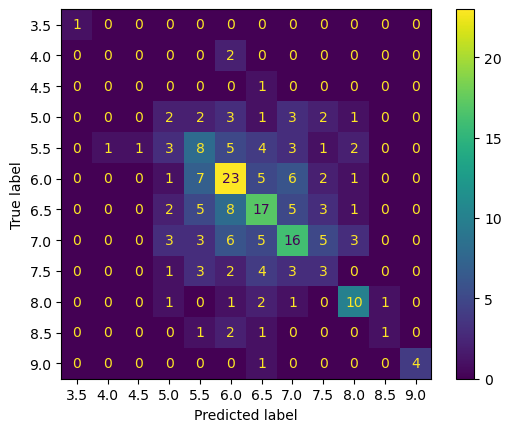

              precision    recall  f1-score   support

         3.5       1.00      1.00      1.00         1
         4.0       0.00      0.00      0.00         2
         4.5       0.00      0.00      0.00         1
         5.0       0.15      0.14      0.15        14
         5.5       0.28      0.29      0.28        28
         6.0       0.44      0.51      0.47        45
         6.5       0.41      0.41      0.41        41
         7.0       0.43      0.39      0.41        41
         7.5       0.19      0.19      0.19        16
         8.0       0.56      0.62      0.59        16
         8.5       0.50      0.20      0.29         5
         9.0       1.00      0.80      0.89         5

    accuracy                           0.40       215
   macro avg       0.41      0.38      0.39       215
weighted avg       0.39      0.40      0.39       215



In [26]:
report(val_y, preds)

In [27]:
accuracy_score(test_y, baseline_pipeline.predict(test_x_base))

0.3813953488372093

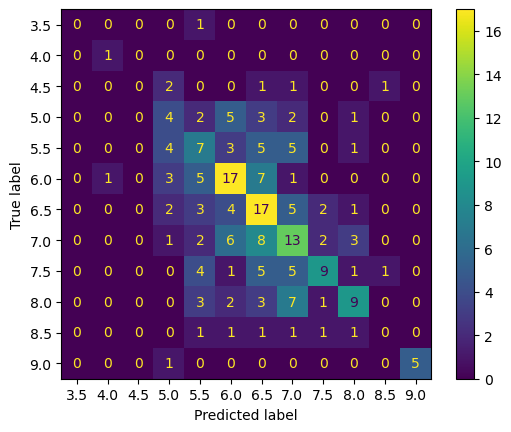

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.0       0.50      1.00      0.67         1
         4.5       0.00      0.00      0.00         5
         5.0       0.24      0.24      0.24        17
         5.5       0.25      0.28      0.26        25
         6.0       0.44      0.50      0.47        34
         6.5       0.34      0.50      0.40        34
         7.0       0.33      0.37      0.35        35
         7.5       0.60      0.35      0.44        26
         8.0       0.53      0.36      0.43        25
         8.5       0.00      0.00      0.00         6
         9.0       1.00      0.83      0.91         6

    accuracy                           0.38       215
   macro avg       0.35      0.37      0.35       215
weighted avg       0.39      0.38      0.37       215



In [28]:
report(test_y, baseline_pipeline.predict(test_x_base))

# LogisticRegression со всеми сгенерированными данными

In [29]:
from sklearn.preprocessing import StandardScaler
Scaler = Pipeline(steps=[
    ("scaler", StandardScaler()),
])

In [30]:
full_data_transformer_features = ColumnTransformer(
    transformers=[
        ("numeric", Scaler, full_numeric_columns),
        ("question", QuestionTextProcessor, ['Question']),
        ("essay", EssayTextProcessor, ['Essay']),
    ])

In [31]:
full_features_preprocessor = Pipeline(steps=[("data_transformer", full_data_transformer_features)])

In [32]:
model_full_features_pipeline = Pipeline( 
    steps=[('preprocessor', full_features_preprocessor),
           ('model', LogisticRegression(max_iter=5000, random_state=42))])

In [142]:
%%time
model_full_features_pipeline.fit(full_train_x, train_y)

CPU times: user 19 s, sys: 132 ms, total: 19.1 s
Wall time: 4.66 s


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['A1', 'A2',
                                                                    'B1', 'B2',
                                                                    'C1', 'C2',
                                                                    'AC',
                                                                    'Min_sim',
                                                                    'Max_sim',
                                                                    'Mean_sim',
                                                                    'readability '
                                                                    'grades-Kincaid',
                                                                    'readability '
                                                                    'grades-ARI',
                                                                    'readability '
                                                                    'grades-Coleman-Liau',
                                                                    'readability '
                                                                    'grades-FleschReadingE...
                                                                   ['Question']),
                                                                  ('essay',
                                                                   Pipeline(steps=[('squeeze',
                                                                                    FunctionTransformer(func=<function <lambda> at 0x7fcbc67100d0>)),
                                                                                   ('tfidf',
                                                                                    TfidfVectorizer(max_df=0.85,
                                                                                                    max_features=450,
                                                                                                    min_df=0.016,
                                                                                                    ngram_range=(1,
                                                                                                                 4),
                                                                                                    norm=None)),
                                                                                   ('toarray',
                                                                                    FunctionTransformer(func=<function <lambda> at 0x7fcbc67104c0>))]),
                                                                   ['Essay'])]))])),
                ('model', LogisticRegression(max_iter=5000, random_state=42))])

In [34]:
%%time
preds = model_full_features_pipeline.predict(full_val_x)

CPU times: user 171 ms, sys: 42 µs, total: 171 ms
Wall time: 170 ms


In [35]:
accuracy_score(val_y, preds)

0.3953488372093023

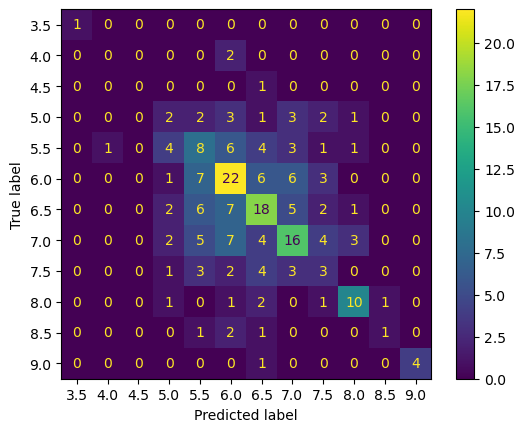

              precision    recall  f1-score   support

         3.5       1.00      1.00      1.00         1
         4.0       0.00      0.00      0.00         2
         4.5       0.00      0.00      0.00         1
         5.0       0.15      0.14      0.15        14
         5.5       0.25      0.29      0.27        28
         6.0       0.42      0.49      0.45        45
         6.5       0.43      0.44      0.43        41
         7.0       0.44      0.39      0.42        41
         7.5       0.19      0.19      0.19        16
         8.0       0.62      0.62      0.62        16
         8.5       0.50      0.20      0.29         5
         9.0       1.00      0.80      0.89         5

    accuracy                           0.40       215
   macro avg       0.42      0.38      0.39       215
weighted avg       0.40      0.40      0.39       215



In [36]:
report(val_y, preds)

In [37]:
accuracy_score(test_y, model_full_features_pipeline.predict(full_test_x))

0.3674418604651163

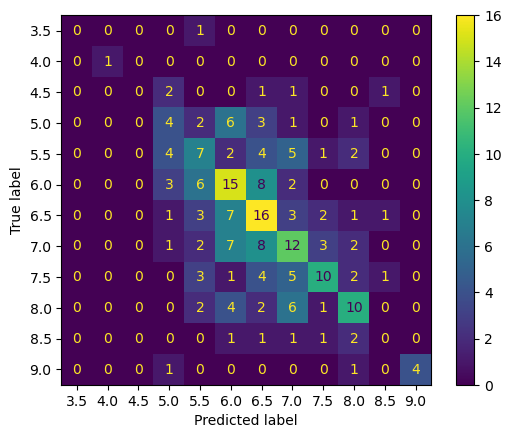

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.0       1.00      1.00      1.00         1
         4.5       0.00      0.00      0.00         5
         5.0       0.25      0.24      0.24        17
         5.5       0.27      0.28      0.27        25
         6.0       0.35      0.44      0.39        34
         6.5       0.34      0.47      0.40        34
         7.0       0.33      0.34      0.34        35
         7.5       0.56      0.38      0.45        26
         8.0       0.48      0.40      0.43        25
         8.5       0.00      0.00      0.00         6
         9.0       1.00      0.67      0.80         6

    accuracy                           0.37       215
   macro avg       0.38      0.35      0.36       215
weighted avg       0.37      0.37      0.36       215



In [38]:
report(test_y, model_full_features_pipeline.predict(full_test_x))

# Та же модель на данных без скоррелированных

In [39]:
clean_data_transformer_features = ColumnTransformer(
    transformers=[
        ("numeric", Scaler, clean_numeric_columns),
        ("question", QuestionTextProcessor, ['Question']),
        ("essay", EssayTextProcessor, ['Essay']),
    ])

In [40]:
log_regression_pipeline = Pipeline( 
    steps=[('preprocessor', clean_data_transformer_features),
           ('model', LogisticRegression(max_iter=5000, random_state=42))])

In [41]:
%%time
log_regression_pipeline.fit(clean_train_x, train_y)

CPU times: user 17.7 s, sys: 160 ms, total: 17.9 s
Wall time: 4.51 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['B1', 'B2', 'C1', 'C2', 'AC',
                                                   'Mean_sim',
                                                   'readability grades-ARI',
                                                   'readability '
                                                   'grades-Coleman-Liau',
                                                   'readability '
                                                   'grades-FleschReadingEase',
                                                   'readability '
                                                   'grades-SMOGIndex',
                                                   'readability '
                                                   'grades-DaleChallIndex',
                                                   'sentence '
                                                   'info-syll_per...
                                                  ['Question']),
                                                 ('essay',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fcbc67100d0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.85,
                                                                                   max_features=450,
                                                                                   min_df=0.016,
                                                                                   ngram_range=(1,
                                                                                                4),
                                                                                   norm=None)),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fcbc67104c0>))]),
                                                  ['Essay'])])),
                ('model', LogisticRegression(max_iter=5000, random_state=42))])

In [42]:
%%time
preds = log_regression_pipeline.predict(clean_val_x)

CPU times: user 382 ms, sys: 12 ms, total: 394 ms
Wall time: 133 ms


In [43]:
accuracy_score(val_y, preds)

0.39069767441860465

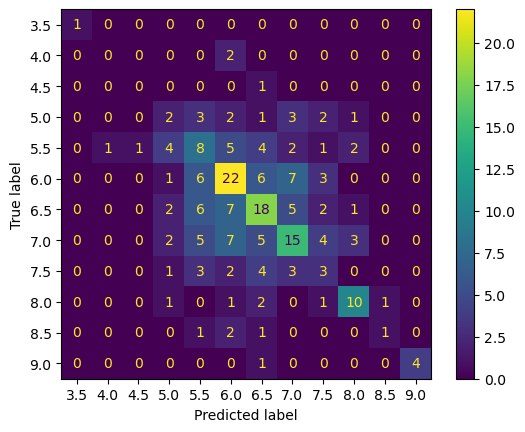

              precision    recall  f1-score   support

         3.5       1.00      1.00      1.00         1
         4.0       0.00      0.00      0.00         2
         4.5       0.00      0.00      0.00         1
         5.0       0.15      0.14      0.15        14
         5.5       0.25      0.29      0.27        28
         6.0       0.44      0.49      0.46        45
         6.5       0.42      0.44      0.43        41
         7.0       0.43      0.37      0.39        41
         7.5       0.19      0.19      0.19        16
         8.0       0.59      0.62      0.61        16
         8.5       0.50      0.20      0.29         5
         9.0       1.00      0.80      0.89         5

    accuracy                           0.39       215
   macro avg       0.41      0.38      0.39       215
weighted avg       0.39      0.39      0.39       215



In [44]:
report(val_y, preds)

In [45]:
accuracy_score(test_y, log_regression_pipeline.predict(clean_test_x))

0.3674418604651163

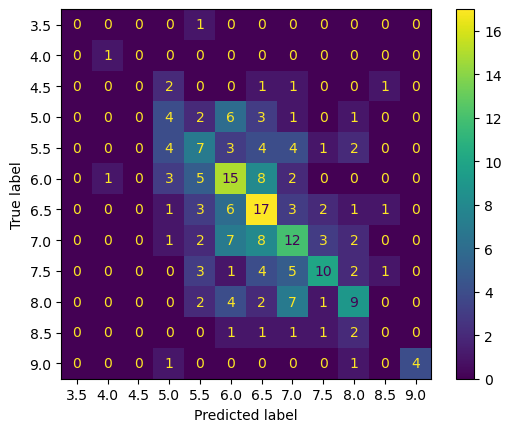

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.0       0.50      1.00      0.67         1
         4.5       0.00      0.00      0.00         5
         5.0       0.25      0.24      0.24        17
         5.5       0.28      0.28      0.28        25
         6.0       0.35      0.44      0.39        34
         6.5       0.35      0.50      0.41        34
         7.0       0.33      0.34      0.34        35
         7.5       0.56      0.38      0.45        26
         8.0       0.45      0.36      0.40        25
         8.5       0.00      0.00      0.00         6
         9.0       1.00      0.67      0.80         6

    accuracy                           0.37       215
   macro avg       0.34      0.35      0.33       215
weighted avg       0.37      0.37      0.36       215



In [46]:
report(test_y, log_regression_pipeline.predict(clean_test_x))

# GradientBoostingClassifier

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

In [48]:
model_boosting_pipeline = Pipeline( 
    steps=[('preprocessor', clean_data_transformer_features),
           ('model', GradientBoostingClassifier(loss='log_loss',
                                                learning_rate=0.11,
                                                n_estimators=600,
                                                subsample=0.5,
                                                criterion='friedman_mse',
                                                max_depth=6,
                                                random_state=42))])

In [144]:
%%time
model_boosting_pipeline.fit(clean_train_x, train_y)

CPU times: user 2min 12s, sys: 35.5 ms, total: 2min 12s
Wall time: 2min 12s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['B1', 'B2', 'C1', 'C2', 'AC',
                                                   'Mean_sim',
                                                   'readability grades-ARI',
                                                   'readability '
                                                   'grades-Coleman-Liau',
                                                   'readability '
                                                   'grades-FleschReadingEase',
                                                   'readability '
                                                   'grades-SMOGIndex',
                                                   'readability '
                                                   'grades-DaleChallIndex',
                                                   'sentence '
                                                   'info-syll_per...
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fcbc67100d0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.85,
                                                                                   max_features=450,
                                                                                   min_df=0.016,
                                                                                   ngram_range=(1,
                                                                                                4),
                                                                                   norm=None)),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fcbc67104c0>))]),
                                                  ['Essay'])])),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.11, max_depth=6,
                                            n_estimators=600, random_state=42,
                                            subsample=0.5))])

In [50]:
%%time
preds = model_boosting_pipeline.predict(clean_val_x)

CPU times: user 133 ms, sys: 3.99 ms, total: 137 ms
Wall time: 136 ms


In [51]:
accuracy_score(val_y, preds)

0.4232558139534884

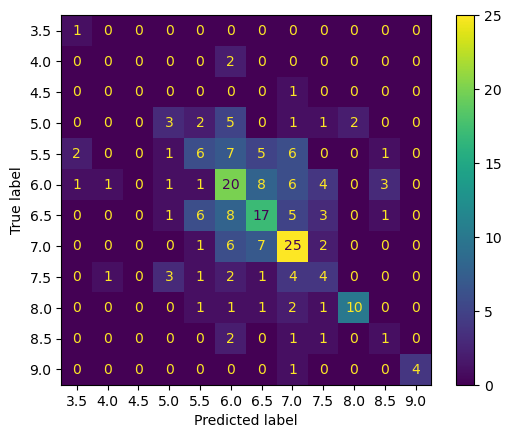

              precision    recall  f1-score   support

         3.5       0.25      1.00      0.40         1
         4.0       0.00      0.00      0.00         2
         4.5       0.00      0.00      0.00         1
         5.0       0.33      0.21      0.26        14
         5.5       0.33      0.21      0.26        28
         6.0       0.38      0.44      0.41        45
         6.5       0.44      0.41      0.43        41
         7.0       0.48      0.61      0.54        41
         7.5       0.25      0.25      0.25        16
         8.0       0.83      0.62      0.71        16
         8.5       0.17      0.20      0.18         5
         9.0       1.00      0.80      0.89         5

    accuracy                           0.42       215
   macro avg       0.37      0.40      0.36       215
weighted avg       0.43      0.42      0.42       215



In [52]:
report(val_y, preds)

In [53]:
accuracy_score(test_y, model_boosting_pipeline.predict(clean_test_x))

0.386046511627907

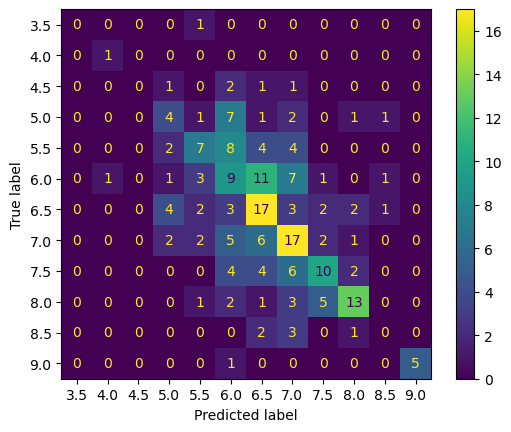

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.0       0.50      1.00      0.67         1
         4.5       0.00      0.00      0.00         5
         5.0       0.29      0.24      0.26        17
         5.5       0.41      0.28      0.33        25
         6.0       0.22      0.26      0.24        34
         6.5       0.36      0.50      0.42        34
         7.0       0.37      0.49      0.42        35
         7.5       0.50      0.38      0.43        26
         8.0       0.65      0.52      0.58        25
         8.5       0.00      0.00      0.00         6
         9.0       1.00      0.83      0.91         6

    accuracy                           0.39       215
   macro avg       0.36      0.38      0.35       215
weighted avg       0.39      0.39      0.38       215



In [54]:
report(test_y, model_boosting_pipeline.predict(clean_test_x))

# RandomForestClassifier

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
model_forest_pipeline = Pipeline( 
    steps=[('preprocessor', clean_data_transformer_features),
           ('model', RandomForestClassifier(n_estimators=250,
                                                criterion='gini',
                                                random_state=42))])

In [57]:
%%time
model_forest_pipeline.fit(clean_train_x, train_y)

CPU times: user 2.72 s, sys: 24 ms, total: 2.75 s
Wall time: 2.75 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['B1', 'B2', 'C1', 'C2', 'AC',
                                                   'Mean_sim',
                                                   'readability grades-ARI',
                                                   'readability '
                                                   'grades-Coleman-Liau',
                                                   'readability '
                                                   'grades-FleschReadingEase',
                                                   'readability '
                                                   'grades-SMOGIndex',
                                                   'readability '
                                                   'grades-DaleChallIndex',
                                                   'sentence '
                                                   'info-syll_per...
                                                 ('essay',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fcbc67100d0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.85,
                                                                                   max_features=450,
                                                                                   min_df=0.016,
                                                                                   ngram_range=(1,
                                                                                                4),
                                                                                   norm=None)),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fcbc67104c0>))]),
                                                  ['Essay'])])),
                ('model',
                 RandomForestClassifier(n_estimators=250, random_state=42))])

In [58]:
%%time
preds = model_forest_pipeline.predict(clean_val_x)

CPU times: user 151 ms, sys: 16 µs, total: 151 ms
Wall time: 151 ms


In [59]:
accuracy_score(val_y, preds)

0.4325581395348837

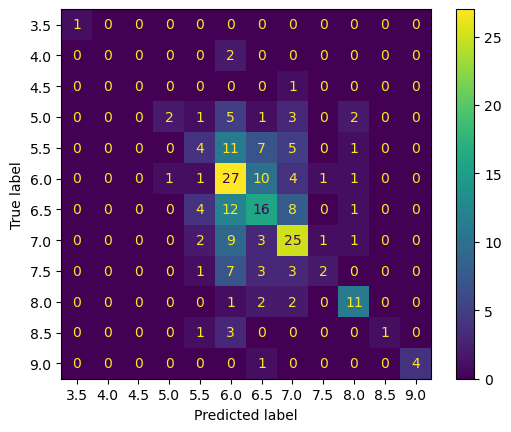

              precision    recall  f1-score   support

         3.5       1.00      1.00      1.00         1
         4.0       0.00      0.00      0.00         2
         4.5       0.00      0.00      0.00         1
         5.0       0.67      0.14      0.24        14
         5.5       0.29      0.14      0.19        28
         6.0       0.35      0.60      0.44        45
         6.5       0.37      0.39      0.38        41
         7.0       0.49      0.61      0.54        41
         7.5       0.50      0.12      0.20        16
         8.0       0.65      0.69      0.67        16
         8.5       1.00      0.20      0.33         5
         9.0       1.00      0.80      0.89         5

    accuracy                           0.43       215
   macro avg       0.53      0.39      0.41       215
weighted avg       0.45      0.43      0.41       215



In [60]:
report(val_y, preds)

In [61]:
accuracy_score(test_y, model_forest_pipeline.predict(clean_test_x))

0.4511627906976744

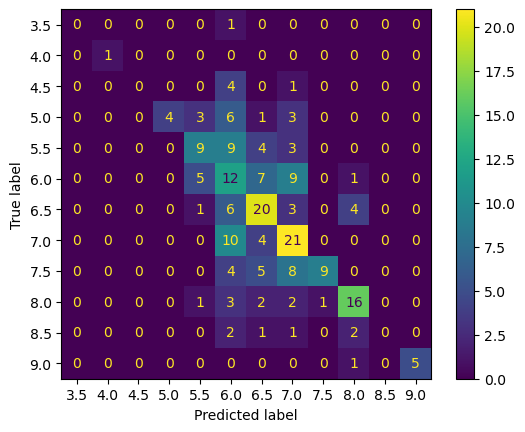

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.0       1.00      1.00      1.00         1
         4.5       0.00      0.00      0.00         5
         5.0       1.00      0.24      0.38        17
         5.5       0.47      0.36      0.41        25
         6.0       0.21      0.35      0.26        34
         6.5       0.45      0.59      0.51        34
         7.0       0.41      0.60      0.49        35
         7.5       0.90      0.35      0.50        26
         8.0       0.67      0.64      0.65        25
         8.5       0.00      0.00      0.00         6
         9.0       1.00      0.83      0.91         6

    accuracy                           0.45       215
   macro avg       0.51      0.41      0.43       215
weighted avg       0.53      0.45      0.45       215



In [62]:
report(test_y, model_forest_pipeline.predict(clean_test_x))

# SVM

In [63]:
from sklearn.svm import SVC

In [64]:
model_svm_pipeline = Pipeline( 
    steps=[('preprocessor', clean_data_transformer_features),
           ('model', SVC(C=3,
                        kernel='linear',
                        random_state=42))])

In [65]:
%%time
model_svm_pipeline.fit(clean_train_x, train_y)

CPU times: user 2.21 s, sys: 20 ms, total: 2.23 s
Wall time: 2.23 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['B1', 'B2', 'C1', 'C2', 'AC',
                                                   'Mean_sim',
                                                   'readability grades-ARI',
                                                   'readability '
                                                   'grades-Coleman-Liau',
                                                   'readability '
                                                   'grades-FleschReadingEase',
                                                   'readability '
                                                   'grades-SMOGIndex',
                                                   'readability '
                                                   'grades-DaleChallIndex',
                                                   'sentence '
                                                   'info-syll_per...
                                                  ['Question']),
                                                 ('essay',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fcbc67100d0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.85,
                                                                                   max_features=450,
                                                                                   min_df=0.016,
                                                                                   ngram_range=(1,
                                                                                                4),
                                                                                   norm=None)),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fcbc67104c0>))]),
                                                  ['Essay'])])),
                ('model', SVC(C=3, kernel='linear', random_state=42))])

In [66]:
%%time
preds = model_svm_pipeline.predict(clean_val_x)

CPU times: user 211 ms, sys: 0 ns, total: 211 ms
Wall time: 211 ms


In [67]:
accuracy_score(val_y, preds)

0.3953488372093023

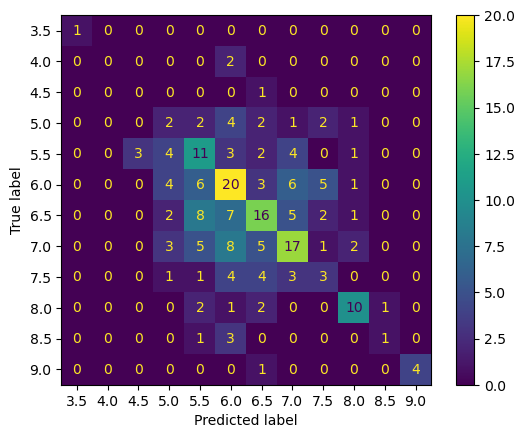

              precision    recall  f1-score   support

         3.5       1.00      1.00      1.00         1
         4.0       0.00      0.00      0.00         2
         4.5       0.00      0.00      0.00         1
         5.0       0.12      0.14      0.13        14
         5.5       0.31      0.39      0.34        28
         6.0       0.38      0.44      0.41        45
         6.5       0.44      0.39      0.42        41
         7.0       0.47      0.41      0.44        41
         7.5       0.23      0.19      0.21        16
         8.0       0.62      0.62      0.62        16
         8.5       0.50      0.20      0.29         5
         9.0       1.00      0.80      0.89         5

    accuracy                           0.40       215
   macro avg       0.42      0.38      0.40       215
weighted avg       0.41      0.40      0.40       215



In [68]:
report(val_y, preds)

In [69]:
accuracy_score(test_y, model_svm_pipeline.predict(clean_test_x))

0.386046511627907

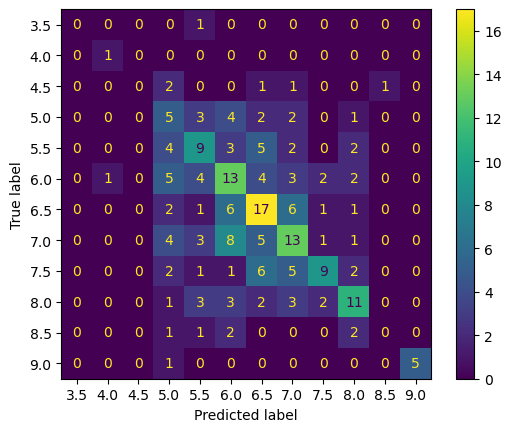

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.0       0.50      1.00      0.67         1
         4.5       0.00      0.00      0.00         5
         5.0       0.19      0.29      0.23        17
         5.5       0.35      0.36      0.35        25
         6.0       0.33      0.38      0.35        34
         6.5       0.40      0.50      0.45        34
         7.0       0.37      0.37      0.37        35
         7.5       0.60      0.35      0.44        26
         8.0       0.50      0.44      0.47        25
         8.5       0.00      0.00      0.00         6
         9.0       1.00      0.83      0.91         6

    accuracy                           0.39       215
   macro avg       0.35      0.38      0.35       215
weighted avg       0.39      0.39      0.38       215



In [70]:
report(test_y, model_svm_pipeline.predict(clean_test_x))

# CatBoostClassifier

In [71]:
from catboost import CatBoostClassifier

In [72]:
catboost_pipeline = Pipeline( 
    steps=[('preprocessor', clean_data_transformer_features),
           ('model', CatBoostClassifier(logging_level='Silent'))])

In [143]:
%%time
catboost_pipeline.fit(clean_train_x, train_y)

CPU times: user 5min 17s, sys: 4.2 s, total: 5min 21s
Wall time: 36.2 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['B1', 'B2', 'C1', 'C2', 'AC',
                                                   'Mean_sim',
                                                   'readability grades-ARI',
                                                   'readability '
                                                   'grades-Coleman-Liau',
                                                   'readability '
                                                   'grades-FleschReadingEase',
                                                   'readability '
                                                   'grades-SMOGIndex',
                                                   'readability '
                                                   'grades-DaleChallIndex',
                                                   'sentence '
                                                   'info-syll_per...
                                                 ('essay',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fcbc67100d0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.85,
                                                                                   max_features=450,
                                                                                   min_df=0.016,
                                                                                   ngram_range=(1,
                                                                                                4),
                                                                                   norm=None)),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fcbc67104c0>))]),
                                                  ['Essay'])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x7fcbbd1c5990>)])

In [74]:
%%time
preds = catboost_pipeline.predict(clean_val_x)

CPU times: user 171 ms, sys: 23 µs, total: 171 ms
Wall time: 167 ms


In [75]:
accuracy_score(val_y, preds)

0.4046511627906977

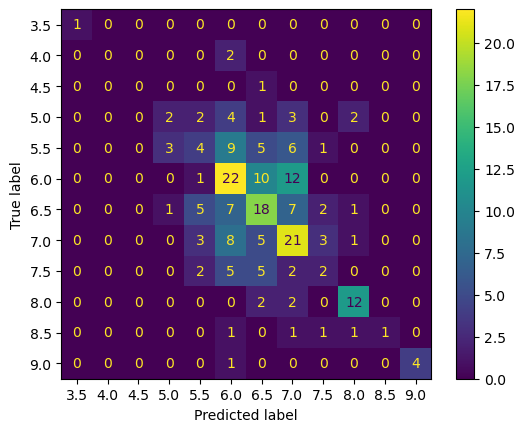

              precision    recall  f1-score   support

         3.5       1.00      1.00      1.00         1
         4.0       0.00      0.00      0.00         2
         4.5       0.00      0.00      0.00         1
         5.0       0.33      0.14      0.20        14
         5.5       0.24      0.14      0.18        28
         6.0       0.37      0.49      0.42        45
         6.5       0.38      0.44      0.41        41
         7.0       0.39      0.51      0.44        41
         7.5       0.22      0.12      0.16        16
         8.0       0.71      0.75      0.73        16
         8.5       1.00      0.20      0.33         5
         9.0       1.00      0.80      0.89         5

    accuracy                           0.40       215
   macro avg       0.47      0.38      0.40       215
weighted avg       0.40      0.40      0.39       215



In [76]:
report(val_y, preds)

In [77]:
accuracy_score(test_y, catboost_pipeline.predict(clean_test_x))

0.4790697674418605

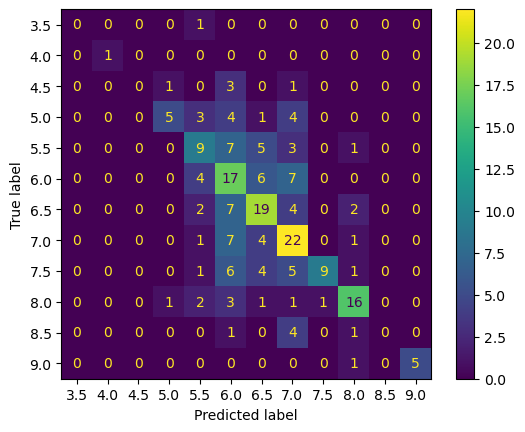

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.0       1.00      1.00      1.00         1
         4.5       0.00      0.00      0.00         5
         5.0       0.71      0.29      0.42        17
         5.5       0.39      0.36      0.37        25
         6.0       0.31      0.50      0.38        34
         6.5       0.47      0.56      0.51        34
         7.0       0.43      0.63      0.51        35
         7.5       0.90      0.35      0.50        26
         8.0       0.70      0.64      0.67        25
         8.5       0.00      0.00      0.00         6
         9.0       1.00      0.83      0.91         6

    accuracy                           0.48       215
   macro avg       0.49      0.43      0.44       215
weighted avg       0.52      0.48      0.47       215



In [78]:
report(test_y, catboost_pipeline.predict(clean_test_x))

# Voting

In [79]:
from sklearn.ensemble import VotingClassifier

In [80]:
boosting = GradientBoostingClassifier(loss='log_loss',
                                                learning_rate=0.11,
                                                n_estimators=600,
                                                subsample=0.5,
                                                criterion='friedman_mse',
                                                max_depth=6,
                                                random_state=42)

In [81]:
svm = SVC(C=3,
        kernel='linear',
        probability=True,
        random_state=42)

In [82]:
forest = RandomForestClassifier(n_estimators=250,
                                criterion='gini',
                                random_state=42)

In [83]:
regression = LogisticRegression(max_iter=5000, random_state=42)

In [84]:
cat = CatBoostClassifier(logging_level='Silent')

In [85]:
weights = [1.8, 0.6, 0.7, 0.3, 2.6]
voting_pipeline = Pipeline( 
    steps=[('preprocessor', clean_data_transformer_features),
           ('model', VotingClassifier(estimators=[
                                               ('gb', boosting),
                                               ('svm', svm),
                                               ('rforest', forest),
                                               ('log_regres', regression),
                                               ('cat', cat)],
                                    voting='soft',
                                    n_jobs=10))])

In [86]:
%%time
voting_pipeline.fit(clean_train_x, train_y)

CPU times: user 2.23 s, sys: 281 ms, total: 2.51 s
Wall time: 2min 40s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['B1', 'B2', 'C1', 'C2', 'AC',
                                                   'Mean_sim',
                                                   'readability grades-ARI',
                                                   'readability '
                                                   'grades-Coleman-Liau',
                                                   'readability '
                                                   'grades-FleschReadingEase',
                                                   'readability '
                                                   'grades-SMOGIndex',
                                                   'readability '
                                                   'grades-DaleChallIndex',
                                                   'sentence '
                                                   'info-syll_per...
                                                                          max_depth=6,
                                                                          n_estimators=600,
                                                                          random_state=42,
                                                                          subsample=0.5)),
                                              ('svm',
                                               SVC(C=3, kernel='linear',
                                                   probability=True,
                                                   random_state=42)),
                                              ('rforest',
                                               RandomForestClassifier(n_estimators=250,
                                                                      random_state=42)),
                                              ('log_regres',
                                               LogisticRegression(max_iter=5000,
                                                                  random_state=42)),
                                              ('cat',
                                               <catboost.core.CatBoostClassifier object at 0x7fcbc348a7d0>)],
                                  n_jobs=10, voting='soft'))])

In [87]:
%%time
preds = voting_pipeline.predict(clean_val_x)

CPU times: user 595 ms, sys: 12.2 ms, total: 607 ms
Wall time: 328 ms


In [88]:
accuracy_score(val_y, preds)

0.4046511627906977

In [89]:
accuracy_score(test_y, voting_pipeline.predict(clean_test_x))

0.413953488372093

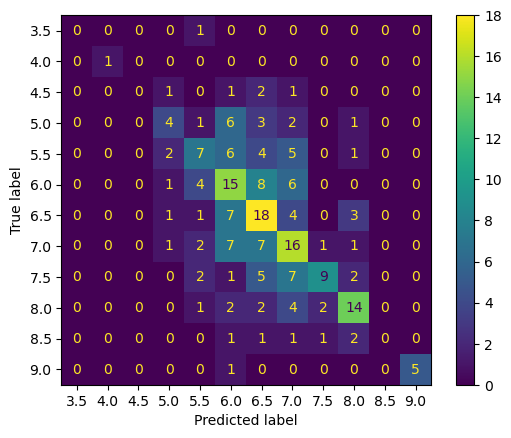

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.0       1.00      1.00      1.00         1
         4.5       0.00      0.00      0.00         5
         5.0       0.40      0.24      0.30        17
         5.5       0.37      0.28      0.32        25
         6.0       0.32      0.44      0.37        34
         6.5       0.36      0.53      0.43        34
         7.0       0.35      0.46      0.40        35
         7.5       0.69      0.35      0.46        26
         8.0       0.58      0.56      0.57        25
         8.5       0.00      0.00      0.00         6
         9.0       1.00      0.83      0.91         6

    accuracy                           0.41       215
   macro avg       0.42      0.39      0.40       215
weighted avg       0.42      0.41      0.40       215



In [90]:
report(test_y, voting_pipeline.predict(clean_test_x))

# VotingClassifier
## Все сгенерированные признаки, вместе с коррелирующими

In [91]:
weights = [1.8, 0.6, 0.7, 0.3, 2.6]
full_voting_pipeline = Pipeline( 
    steps=[('preprocessor', full_features_preprocessor),
           ('model', VotingClassifier(estimators=[
                                               ('gb', boosting),
                                               ('svm', svm),
                                               ('rforest', forest),
                                               ('log_regres', regression),
                                               ('cat', cat)],
                                    voting='soft',
                                    n_jobs=10))])

In [92]:
%%time
full_voting_pipeline.fit(full_train_x, train_y)

CPU times: user 2.17 s, sys: 112 ms, total: 2.28 s
Wall time: 2min 59s


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['A1', 'A2',
                                                                    'B1', 'B2',
                                                                    'C1', 'C2',
                                                                    'AC',
                                                                    'Min_sim',
                                                                    'Max_sim',
                                                                    'Mean_sim',
                                                                    'readability '
                                                                    'grades-Kincaid',
                                                                    'readability '
                                                                    'grades-ARI',
                                                                    'readability '
                                                                    'grades-Coleman-Liau',
                                                                    'readability '
                                                                    'grades-FleschReadingE...
                                                                          max_depth=6,
                                                                          n_estimators=600,
                                                                          random_state=42,
                                                                          subsample=0.5)),
                                              ('svm',
                                               SVC(C=3, kernel='linear',
                                                   probability=True,
                                                   random_state=42)),
                                              ('rforest',
                                               RandomForestClassifier(n_estimators=250,
                                                                      random_state=42)),
                                              ('log_regres',
                                               LogisticRegression(max_iter=5000,
                                                                  random_state=42)),
                                              ('cat',
                                               <catboost.core.CatBoostClassifier object at 0x7fcbc348a7d0>)],
                                  n_jobs=10, voting='soft'))])

In [93]:
%%time
preds = full_voting_pipeline.predict(full_val_x)

CPU times: user 723 ms, sys: 3.89 ms, total: 727 ms
Wall time: 331 ms


In [94]:
accuracy_score(val_y, preds)

0.42790697674418604

In [95]:
accuracy_score(test_y, full_voting_pipeline.predict(full_test_x))

0.4232558139534884

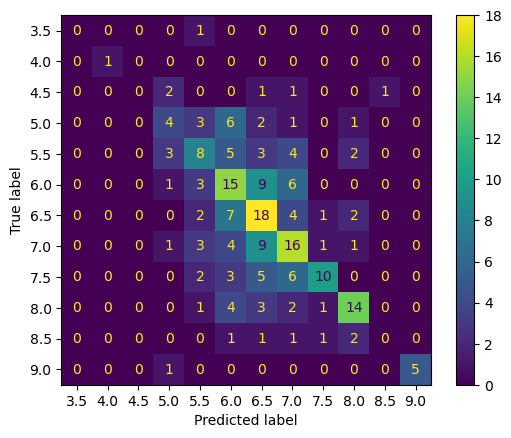

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.0       1.00      1.00      1.00         1
         4.5       0.00      0.00      0.00         5
         5.0       0.33      0.24      0.28        17
         5.5       0.35      0.32      0.33        25
         6.0       0.33      0.44      0.38        34
         6.5       0.35      0.53      0.42        34
         7.0       0.39      0.46      0.42        35
         7.5       0.71      0.38      0.50        26
         8.0       0.64      0.56      0.60        25
         8.5       0.00      0.00      0.00         6
         9.0       1.00      0.83      0.91         6

    accuracy                           0.42       215
   macro avg       0.43      0.40      0.40       215
weighted avg       0.43      0.42      0.42       215



In [96]:
report(test_y, full_voting_pipeline.predict(full_test_x))

## Начальные признаки

In [97]:
weights = [1.8, 0.6, 0.7, 0.3, 2.6]
base_voting_pipeline = Pipeline( 
    steps=[('preprocessor', baseline_preprocessor),
           ('model', VotingClassifier(estimators=[
                                               ('gb', boosting),
                                               ('svm', svm),
                                               ('rforest', forest),
                                               ('log_regres', regression),
                                               ('cat', cat)],
                                    voting='soft',
                                    n_jobs=10))])

In [98]:
%%time
base_voting_pipeline.fit(train_x_base, train_y)

CPU times: user 2.04 s, sys: 200 ms, total: 2.24 s
Wall time: 2min 7s


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('question',
                                                                   Pipeline(steps=[('squeeze',
                                                                                    FunctionTransformer(func=<function <lambda> at 0x7fcbc67105e0>)),
                                                                                   ('tfidf',
                                                                                    TfidfVectorizer(max_df=0.95,
                                                                                                    max_features=800,
                                                                                                    min_df=0.01,
                                                                                                    ngram_range=(1,
                                                                                                                 3),
                                                                                                    norm=None)),
                                                                                   ('toarray',
                                                                                    FunctionTransformer(func=<function <lambda>...
                                                                          max_depth=6,
                                                                          n_estimators=600,
                                                                          random_state=42,
                                                                          subsample=0.5)),
                                              ('svm',
                                               SVC(C=3, kernel='linear',
                                                   probability=True,
                                                   random_state=42)),
                                              ('rforest',
                                               RandomForestClassifier(n_estimators=250,
                                                                      random_state=42)),
                                              ('log_regres',
                                               LogisticRegression(max_iter=5000,
                                                                  random_state=42)),
                                              ('cat',
                                               <catboost.core.CatBoostClassifier object at 0x7fcbc348a7d0>)],
                                  n_jobs=10, voting='soft'))])

In [99]:
%%time
preds = base_voting_pipeline.predict(val_x_base)

CPU times: user 563 ms, sys: 3.9 ms, total: 567 ms
Wall time: 294 ms


In [100]:
accuracy_score(val_y, preds)

0.40930232558139534

In [101]:
accuracy_score(test_y, base_voting_pipeline.predict(test_x_base))

0.4046511627906977

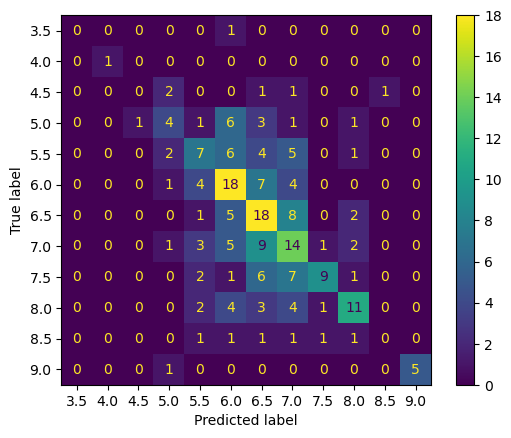

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.0       1.00      1.00      1.00         1
         4.5       0.00      0.00      0.00         5
         5.0       0.36      0.24      0.29        17
         5.5       0.33      0.28      0.30        25
         6.0       0.38      0.53      0.44        34
         6.5       0.35      0.53      0.42        34
         7.0       0.31      0.40      0.35        35
         7.5       0.75      0.35      0.47        26
         8.0       0.58      0.44      0.50        25
         8.5       0.00      0.00      0.00         6
         9.0       1.00      0.83      0.91         6

    accuracy                           0.40       215
   macro avg       0.42      0.38      0.39       215
weighted avg       0.42      0.40      0.40       215



In [102]:
report(test_y, base_voting_pipeline.predict(test_x_base))

## Простые признаки

In [103]:
simple_data_transformer_features = ColumnTransformer(
    transformers=[
        ("numeric", Scaler, numeric_columns_simple),
        ("question", QuestionTextProcessor, ['Question']),
        ("essay", EssayTextProcessor, ['Essay']),
    ])

In [104]:
weights = [1.8, 0.6, 0.7, 0.3, 2.6]
simple_voting_pipeline = Pipeline( 
    steps=[('preprocessor', simple_data_transformer_features),
           ('model', VotingClassifier(estimators=[
                                               ('gb', boosting),
                                               ('svm', svm),
                                               ('rforest', forest),
                                               ('log_regres', regression),
                                               ('cat', cat)],
                                    voting='soft',
                                    n_jobs=10))])

In [105]:
%%time
simple_voting_pipeline.fit(train_x_simple, train_y)

CPU times: user 2.08 s, sys: 96.2 ms, total: 2.18 s
Wall time: 2min 10s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['B1', 'B2', 'C1', 'C2', 'AC',
                                                   'Mean_sim']),
                                                 ('question',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fcbc67105e0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.95,
                                                                                   max_features=800,
                                                                                   min_df=0.01,
                                                                                   ngram_range=(1,
                                                                                                3),
                                                                                   norm=...
                                                                          max_depth=6,
                                                                          n_estimators=600,
                                                                          random_state=42,
                                                                          subsample=0.5)),
                                              ('svm',
                                               SVC(C=3, kernel='linear',
                                                   probability=True,
                                                   random_state=42)),
                                              ('rforest',
                                               RandomForestClassifier(n_estimators=250,
                                                                      random_state=42)),
                                              ('log_regres',
                                               LogisticRegression(max_iter=5000,
                                                                  random_state=42)),
                                              ('cat',
                                               <catboost.core.CatBoostClassifier object at 0x7fcbc348a7d0>)],
                                  n_jobs=10, voting='soft'))])

In [106]:
%%time
preds = simple_voting_pipeline.predict(val_x_simple)

CPU times: user 716 ms, sys: 90 µs, total: 716 ms
Wall time: 318 ms


In [107]:
accuracy_score(val_y, preds)

0.413953488372093

In [108]:
accuracy_score(test_y, simple_voting_pipeline.predict(test_x_simple))

0.40930232558139534

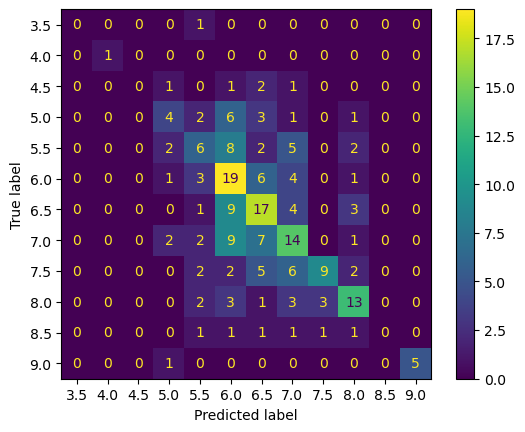

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.0       1.00      1.00      1.00         1
         4.5       0.00      0.00      0.00         5
         5.0       0.36      0.24      0.29        17
         5.5       0.30      0.24      0.27        25
         6.0       0.33      0.56      0.41        34
         6.5       0.39      0.50      0.44        34
         7.0       0.36      0.40      0.38        35
         7.5       0.69      0.35      0.46        26
         8.0       0.54      0.52      0.53        25
         8.5       0.00      0.00      0.00         6
         9.0       1.00      0.83      0.91         6

    accuracy                           0.41       215
   macro avg       0.41      0.39      0.39       215
weighted avg       0.41      0.41      0.40       215



In [109]:
report(test_y, simple_voting_pipeline.predict(test_x_simple))

## Сложные признаки

In [110]:
complex_data_transformer_features = ColumnTransformer(
    transformers=[
        ("numeric", Scaler, numeric_columns_complex),
        ("question", QuestionTextProcessor, ['Question']),
        ("essay", EssayTextProcessor, ['Essay']),
    ])

In [111]:
weights = [1.8, 0.6, 0.7, 0.3, 2.6]
complex_voting_pipeline = Pipeline( 
    steps=[('preprocessor', complex_data_transformer_features),
           ('model', VotingClassifier(estimators=[
                                               ('gb', boosting),
                                               ('svm', svm),
                                               ('rforest', forest),
                                               ('log_regres', regression),
                                               ('cat', cat)],
                                    voting='soft',
                                    n_jobs=10))])

In [112]:
%%time
complex_voting_pipeline.fit(train_x_complex, train_y)

CPU times: user 2.15 s, sys: 116 ms, total: 2.26 s
Wall time: 2min 31s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['readability grades-ARI',
                                                   'readability '
                                                   'grades-Coleman-Liau',
                                                   'readability '
                                                   'grades-FleschReadingEase',
                                                   'readability '
                                                   'grades-SMOGIndex',
                                                   'readability '
                                                   'grades-DaleChallIndex',
                                                   'sentence '
                                                   'info-syll_per_word',
                                                   'sentence '
                                                   'info-type_token_ra...
                                                                          max_depth=6,
                                                                          n_estimators=600,
                                                                          random_state=42,
                                                                          subsample=0.5)),
                                              ('svm',
                                               SVC(C=3, kernel='linear',
                                                   probability=True,
                                                   random_state=42)),
                                              ('rforest',
                                               RandomForestClassifier(n_estimators=250,
                                                                      random_state=42)),
                                              ('log_regres',
                                               LogisticRegression(max_iter=5000,
                                                                  random_state=42)),
                                              ('cat',
                                               <catboost.core.CatBoostClassifier object at 0x7fcbc348a7d0>)],
                                  n_jobs=10, voting='soft'))])

In [113]:
%%time
preds = complex_voting_pipeline.predict(val_x_complex)

CPU times: user 579 ms, sys: 72 µs, total: 579 ms
Wall time: 312 ms


In [114]:
accuracy_score(val_y, preds)

0.39069767441860465

In [115]:
accuracy_score(test_y, complex_voting_pipeline.predict(test_x_complex))

0.4372093023255814

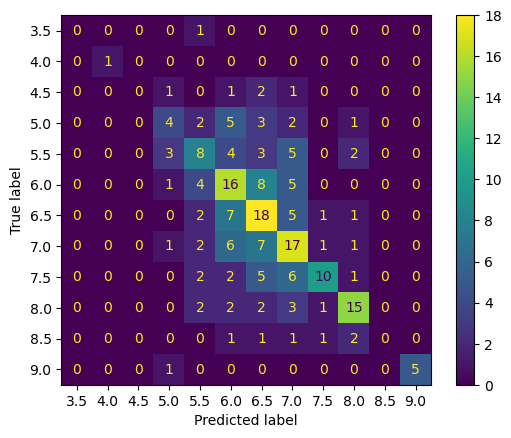

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.0       1.00      1.00      1.00         1
         4.5       0.00      0.00      0.00         5
         5.0       0.36      0.24      0.29        17
         5.5       0.35      0.32      0.33        25
         6.0       0.36      0.47      0.41        34
         6.5       0.37      0.53      0.43        34
         7.0       0.38      0.49      0.42        35
         7.5       0.71      0.38      0.50        26
         8.0       0.65      0.60      0.63        25
         8.5       0.00      0.00      0.00         6
         9.0       1.00      0.83      0.91         6

    accuracy                           0.44       215
   macro avg       0.43      0.40      0.41       215
weighted avg       0.44      0.44      0.43       215



In [116]:
report(test_y, complex_voting_pipeline.predict(test_x_complex))

# RandomForest
## Все сгенерированные признаки, вместе с коррелирующими

In [117]:
forest_model = RandomForestClassifier(n_estimators=250,
                                                criterion='gini',
                                                random_state=42)

In [118]:
full_forest_pipeline = Pipeline( 
    steps=[('preprocessor', full_features_preprocessor),
           ('model', forest_model)])

In [119]:
%%time
full_forest_pipeline.fit(full_train_x, train_y)

CPU times: user 2.77 s, sys: 36.1 ms, total: 2.8 s
Wall time: 2.81 s


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['A1', 'A2',
                                                                    'B1', 'B2',
                                                                    'C1', 'C2',
                                                                    'AC',
                                                                    'Min_sim',
                                                                    'Max_sim',
                                                                    'Mean_sim',
                                                                    'readability '
                                                                    'grades-Kincaid',
                                                                    'readability '
                                                                    'grades-ARI',
                                                                    'readability '
                                                                    'grades-Coleman-Liau',
                                                                    'readability '
                                                                    'grades-FleschReadingE...
                                                                  ('essay',
                                                                   Pipeline(steps=[('squeeze',
                                                                                    FunctionTransformer(func=<function <lambda> at 0x7fcbc67100d0>)),
                                                                                   ('tfidf',
                                                                                    TfidfVectorizer(max_df=0.85,
                                                                                                    max_features=450,
                                                                                                    min_df=0.016,
                                                                                                    ngram_range=(1,
                                                                                                                 4),
                                                                                                    norm=None)),
                                                                                   ('toarray',
                                                                                    FunctionTransformer(func=<function <lambda> at 0x7fcbc67104c0>))]),
                                                                   ['Essay'])]))])),
                ('model',
                 RandomForestClassifier(n_estimators=250, random_state=42))])

In [120]:
%%time
preds = full_forest_pipeline.predict(full_val_x)

CPU times: user 152 ms, sys: 0 ns, total: 152 ms
Wall time: 152 ms


In [121]:
accuracy_score(val_y, preds)

0.386046511627907

In [122]:
accuracy_score(test_y, full_forest_pipeline.predict(full_test_x))

0.46511627906976744

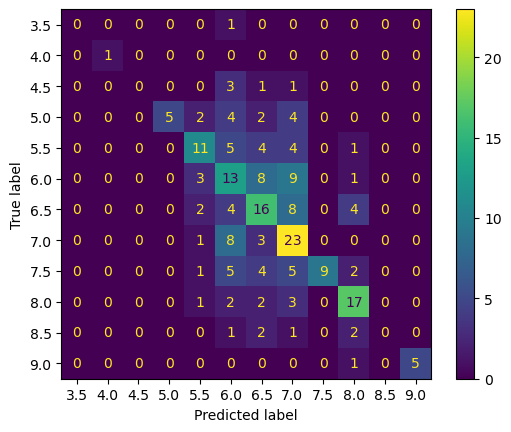

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.0       1.00      1.00      1.00         1
         4.5       0.00      0.00      0.00         5
         5.0       1.00      0.29      0.45        17
         5.5       0.52      0.44      0.48        25
         6.0       0.28      0.38      0.33        34
         6.5       0.38      0.47      0.42        34
         7.0       0.40      0.66      0.49        35
         7.5       1.00      0.35      0.51        26
         8.0       0.61      0.68      0.64        25
         8.5       0.00      0.00      0.00         6
         9.0       1.00      0.83      0.91         6

    accuracy                           0.47       215
   macro avg       0.52      0.43      0.44       215
weighted avg       0.53      0.47      0.46       215



In [123]:
report(test_y, full_forest_pipeline.predict(full_test_x))

## Начальные признаки

In [124]:
base_forest_pipeline = Pipeline( 
    steps=[('preprocessor', baseline_preprocessor),
           ('model', forest_model)])

In [125]:
%%time
base_forest_pipeline.fit(train_x_base, train_y)

CPU times: user 2.68 s, sys: 36 ms, total: 2.71 s
Wall time: 2.71 s


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('question',
                                                                   Pipeline(steps=[('squeeze',
                                                                                    FunctionTransformer(func=<function <lambda> at 0x7fcbc67105e0>)),
                                                                                   ('tfidf',
                                                                                    TfidfVectorizer(max_df=0.95,
                                                                                                    max_features=800,
                                                                                                    min_df=0.01,
                                                                                                    ngram_range=(1,
                                                                                                                 3),
                                                                                                    norm=None)),
                                                                                   ('toarray',
                                                                                    FunctionTransformer(func=<function <lambda>...
                                                                  ('essay',
                                                                   Pipeline(steps=[('squeeze',
                                                                                    FunctionTransformer(func=<function <lambda> at 0x7fcbc67100d0>)),
                                                                                   ('tfidf',
                                                                                    TfidfVectorizer(max_df=0.85,
                                                                                                    max_features=450,
                                                                                                    min_df=0.016,
                                                                                                    ngram_range=(1,
                                                                                                                 4),
                                                                                                    norm=None)),
                                                                                   ('toarray',
                                                                                    FunctionTransformer(func=<function <lambda> at 0x7fcbc67104c0>))]),
                                                                   ['Essay'])]))])),
                ('model',
                 RandomForestClassifier(n_estimators=250, random_state=42))])

In [126]:
%%time
preds = base_forest_pipeline.predict(val_x_base)

CPU times: user 147 ms, sys: 0 ns, total: 147 ms
Wall time: 146 ms


In [127]:
accuracy_score(val_y, preds)

0.3813953488372093

In [128]:
accuracy_score(test_y, base_forest_pipeline.predict(test_x_base))

0.3674418604651163

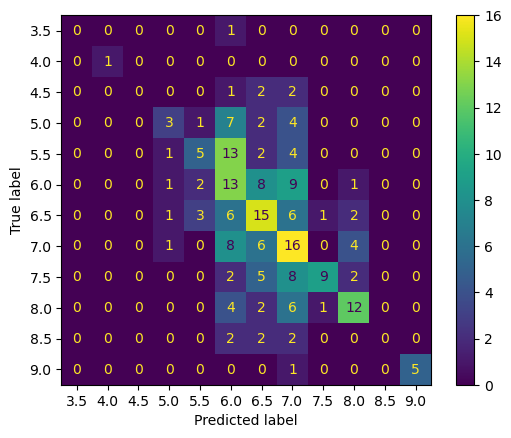

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.0       1.00      1.00      1.00         1
         4.5       0.00      0.00      0.00         5
         5.0       0.43      0.18      0.25        17
         5.5       0.45      0.20      0.28        25
         6.0       0.23      0.38      0.29        34
         6.5       0.34      0.44      0.38        34
         7.0       0.28      0.46      0.34        35
         7.5       0.82      0.35      0.49        26
         8.0       0.57      0.48      0.52        25
         8.5       0.00      0.00      0.00         6
         9.0       1.00      0.83      0.91         6

    accuracy                           0.37       215
   macro avg       0.43      0.36      0.37       215
weighted avg       0.42      0.37      0.36       215



In [129]:
report(test_y, base_forest_pipeline.predict(test_x_base))

## Простые признаки

In [130]:
simple_forest_pipeline = Pipeline( 
    steps=[('preprocessor', simple_data_transformer_features),
           ('model', forest_model)])

In [131]:
%%time
simple_forest_pipeline.fit(train_x_simple, train_y)

CPU times: user 2.71 s, sys: 20 ms, total: 2.73 s
Wall time: 2.73 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['B1', 'B2', 'C1', 'C2', 'AC',
                                                   'Mean_sim']),
                                                 ('question',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fcbc67105e0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.95,
                                                                                   max_features=800,
                                                                                   min_df=0.01,
                                                                                   ngram_range=(1,
                                                                                                3),
                                                                                   norm=...
                                                 ('essay',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fcbc67100d0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.85,
                                                                                   max_features=450,
                                                                                   min_df=0.016,
                                                                                   ngram_range=(1,
                                                                                                4),
                                                                                   norm=None)),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fcbc67104c0>))]),
                                                  ['Essay'])])),
                ('model',
                 RandomForestClassifier(n_estimators=250, random_state=42))])

In [132]:
%%time
preds = simple_forest_pipeline.predict(val_x_simple)

CPU times: user 149 ms, sys: 3 µs, total: 149 ms
Wall time: 148 ms


In [133]:
accuracy_score(val_y, preds)

0.386046511627907

In [134]:
accuracy_score(test_y, simple_forest_pipeline.predict(test_x_simple))

0.4372093023255814

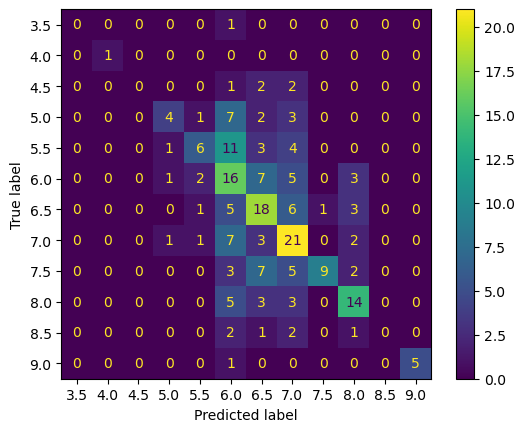

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.0       1.00      1.00      1.00         1
         4.5       0.00      0.00      0.00         5
         5.0       0.57      0.24      0.33        17
         5.5       0.55      0.24      0.33        25
         6.0       0.27      0.47      0.34        34
         6.5       0.39      0.53      0.45        34
         7.0       0.41      0.60      0.49        35
         7.5       0.90      0.35      0.50        26
         8.0       0.56      0.56      0.56        25
         8.5       0.00      0.00      0.00         6
         9.0       1.00      0.83      0.91         6

    accuracy                           0.44       215
   macro avg       0.47      0.40      0.41       215
weighted avg       0.49      0.44      0.43       215



In [135]:
report(test_y, simple_forest_pipeline.predict(test_x_simple))

## Сложные признаки

In [136]:
complex_forest_pipeline = Pipeline( 
    steps=[('preprocessor', complex_data_transformer_features),
           ('model', forest_model)])

In [137]:
%%time
complex_forest_pipeline.fit(train_x_complex, train_y)

CPU times: user 2.77 s, sys: 16 ms, total: 2.79 s
Wall time: 2.79 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['readability grades-ARI',
                                                   'readability '
                                                   'grades-Coleman-Liau',
                                                   'readability '
                                                   'grades-FleschReadingEase',
                                                   'readability '
                                                   'grades-SMOGIndex',
                                                   'readability '
                                                   'grades-DaleChallIndex',
                                                   'sentence '
                                                   'info-syll_per_word',
                                                   'sentence '
                                                   'info-type_token_ra...
                                                 ('essay',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fcbc67100d0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.85,
                                                                                   max_features=450,
                                                                                   min_df=0.016,
                                                                                   ngram_range=(1,
                                                                                                4),
                                                                                   norm=None)),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fcbc67104c0>))]),
                                                  ['Essay'])])),
                ('model',
                 RandomForestClassifier(n_estimators=250, random_state=42))])

In [138]:
%%time
preds = complex_forest_pipeline.predict(val_x_complex)

CPU times: user 141 ms, sys: 3.94 ms, total: 145 ms
Wall time: 144 ms


In [139]:
accuracy_score(val_y, preds)

0.39069767441860465

In [140]:
accuracy_score(test_y, complex_forest_pipeline.predict(test_x_complex))

0.4418604651162791

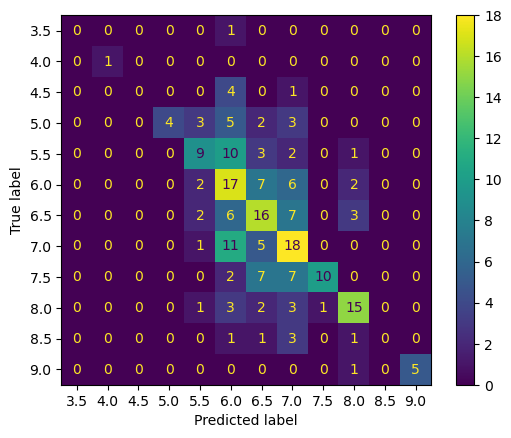

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.0       1.00      1.00      1.00         1
         4.5       0.00      0.00      0.00         5
         5.0       1.00      0.24      0.38        17
         5.5       0.50      0.36      0.42        25
         6.0       0.28      0.50      0.36        34
         6.5       0.37      0.47      0.42        34
         7.0       0.36      0.51      0.42        35
         7.5       0.91      0.38      0.54        26
         8.0       0.65      0.60      0.63        25
         8.5       0.00      0.00      0.00         6
         9.0       1.00      0.83      0.91         6

    accuracy                           0.44       215
   macro avg       0.51      0.41      0.42       215
weighted avg       0.52      0.44      0.44       215



In [141]:
report(test_y, complex_forest_pipeline.predict(test_x_complex))

# Независимая проверка

In [142]:
from typing import List
import readability
from prepoc_func import lemmatize_column, question_embeddings
from prepoc_func import get_word_features, tokenize_text
from prepoc_func import sum_embeddings, similarity_counter


def get_data(questions: List[str], samples: List[str], tasks: List[str]):
    data = pd.DataFrame({'Question': questions,
                        'Essay': samples,
                        'Task_Type': tasks})
    
    data = get_word_features(data, 'Essay')

    embedded_question = question_embeddings(data, 'Question')
    summarized_essay = sum_embeddings(data, 'Essay')
    similarity_data = similarity_counter(embedded_question['Question'],
                                         summarized_essay['Summ_paragraph'])
    data = pd.concat([data, similarity_data], axis=1)
    
    results_columns = readability.getmeasures(tokenize_text(data.loc[0, 'Essay']), lang='en')
    
    all_features = []
    for high_level_index in list(results_columns.keys()):
        for low_level_index in list(results_columns[high_level_index].keys()):
            all_features.append('-'.join([high_level_index, low_level_index]))

    for feature in all_features:
        data[feature] = None
    for item in tqdm(data.index):
        results = readability.getmeasures(tokenize_text(data.loc[item, 'Essay']), lang='en')
        for high_level_index in list(results.keys()):
            for low_level_index in list(results[high_level_index].keys()):
                data.loc[item, '-'.join([high_level_index, low_level_index])] =(
                                             results[high_level_index][low_level_index])
    lemmatized_data = data.copy().drop(['Question', 'Essay'], axis=1)
    lemmatized_data['Question'] = lemmatize_column(data, 'Question')
    lemmatized_data['Essay'] = lemmatize_column(data, 'Essay')
    return lemmatized_data

In [143]:
def get_prediction(data, model):
    return model.predict(data)

In [144]:
question_1 = 'The table shows forested land in millions of hectares in different parts of the world. Summarise the information by selecting and reporting the main features, and make comparisons where relevant.'
task_1 = '1'
essay_1 = """In that table data with dynamics of forested areas of different parts of the world.
The observation embraces 15 years from 1990 to 2005.
There are several trends there both positive and negative.
Firstly, in given period South America and Africa decreased their forested areas  by about 50 million hectares. This problem, probably, can be explained by extensive development of the region economics. 
However, Asia has brilliant results: they conquered deforestation and in 5 years increased amount of forests  by 14 million hectares, despite their economics grow rapidly.
Positive dynamics also observed in North America and Oceania, where forestation level remained constant. Moreover, in Europe it even slightly increased.
This data reflect the main difference between intensively and extensively growing economics: more developed countries tend to care about ecology and they have resources to protect their environment, whereas poorer regions unable to grow and invest in ecology at the same time.
So, Africa and South America possessing significant natural resources and the trend to deforestation of that areas looks explanable but exsessively alarming."""

In [145]:
question_2 = 'Computers are often argued to be the most important invention of the last hundred years. To what extent do you agree or disagree with this statement? Give reasons for your answer and include any relevant examples from your own knowledge or experience.'
task_2 = '2'
essay_2 = """Many people believe that the computer is the most significant invention of humankind, whereas others doubt about its importance. In my opinion, it's hard to overestimate the impact of the computer creation.
Firstly, there is a number evidence that  improvement in computation speed benefits all scientific fields. Throughout our history, we accumulated enormous amount of information in different disciplines, that needed to be processed. As a result, today we have many discoveries made because of calculations performed by computing machines.
Secondly, computers allow us to collect new data and analyse it. I believe that absolutely new, rapidly growing field of Big Data will provide scientists with fresh insights about nature of our world.
One can argue that  some discoveries, such as synthesis of antibiotics, are more beneficial then simply computing machienes. However, today fast calculus are used for projecting new drug formulas  and, in my opinion, in that aspect computer won again.
It would be a mistake to consider computer as a single invention. It is a whole system revolutionized science and our daily life.
Moreover, almost all business highly depends on fast and accurate computation. Not so many factories are able to function without computers support. We rely on them for planning, storage, producing, selling and quality control of production. Furthermore, we even communicate with our gadgets, that are just tiny computers.
So, the computer is a kind of a path to the bright future for all human beings. And it's not only a single invention but the door leading to new evolution of our reality."""

In [146]:
frame = get_data([question_1, question_2],
                       [essay_1, essay_2],
                       [task_1, task_2])

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/1239 [00:00<?, ?it/s]

  0%|          | 0/2162 [00:00<?, ?it/s]

  0%|          | 0/3105 [00:00<?, ?it/s]

  0%|          | 0/1823 [00:00<?, ?it/s]

  0%|          | 0/2695 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Word of not found
Word of not found
Word summarise not found
Word and not found
Word and not found
Word to not found
Word of not found
Word to not found
Word and not found


  0%|          | 0/2 [00:00<?, ?it/s]

Word datum not found
Word of not found
Word of not found
Word of not found
Word to not found
Word and not found
Word and not found
Word africa not found
Word of not found
Word asia not found
Word and not found
Word of not found
Word and not found
Word oceania not found
Word forestation not found
Word europe not found
Word datum not found
Word and not found
Word to not found
Word and not found
Word to not found
Word to not found
Word and not found
Word africa not found
Word and not found
Word and not found
Word to not found
Word of not found
Word explanable not found
Word exsessively not found
Word of not found
Word to not found
Word of not found
Word a not found
Word of not found
Word to not found
Word a not found
Word of not found
Word to not found
Word datum not found
Word and not found
Word analyse not found
Word of not found
Word datum not found
Word of not found
Word of not found
Word machiene not found
Word and not found
Word a not found
Word to not found
Word a not found
Word a 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [147]:
frame

,Task_Type,A1,A2,B1,B2,C1,C2,AC,Min_sim,Max_sim,...,word usage-preposition,word usage-nominalization,sentence beginnings-pronoun,sentence beginnings-interrogative,sentence beginnings-article,sentence beginnings-subordination,sentence beginnings-conjunction,sentence beginnings-preposition,Question,Essay
0,1,249,361,24,207,9,10,25,0.495182,0.826747,...,28,7,2,0,1,0,0,1,the table show forested land in million of he...,in that table datum with dynamic of forested ...
1,2,415,560,41,325,8,24,25,0.765670,0.846903,...,32,14,4,0,0,1,1,2,computer be often argue to be the most import...,many people believe that the computer be the ...


In [148]:
prediction = get_prediction(frame, full_voting_pipeline)

In [149]:
prediction

array(['7.0', '6.5'], dtype=object)

In [150]:
prediction_rf = get_prediction(frame, model_forest_pipeline)

In [151]:
prediction_rf

array(['6.0', '7.0'], dtype=object)